In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import xarray as xr
from matplotlib.colors import Normalize
from mmctools.helper_functions import calc_uv
from mpl_toolkits.basemap import Basemap
from collections import Counter

# Read in and convert the data into xarrays

In [4]:
fdir  = '/Users/hawbecke/Research/Chesapeake/Data/'
fname = 'Maryland_ASOS_Jan2011toOct2019.txt'

In [5]:
df = pd.read_csv('{}{}'.format(fdir,fname),parse_dates=True,index_col='valid' )

df = df[~df.index.duplicated()]

ds = df.set_index([pd.to_datetime(df.index),'station']).to_xarray()

# Find unique station identifiers

In [6]:
stn_lon = []
stn_lat = []
for ss in ds.get_index('station'):
    stn_lon.append(np.nanmax(ds.sel(station=ss).lon))
    stn_lat.append(np.nanmax(ds.sel(station=ss).lat))
nstations = np.shape(ds.get_index('station'))[0]

ds['lon'] = (['station'],stn_lon)
ds['lat'] = (['station'],stn_lat)
ds = ds.assign_coords(lat=ds.lat).assign_coords(lon=ds.lon).rename({'valid':'datetime'})

In [7]:
ds

<xarray.Dataset>
Dimensions:            (datetime: 1385884, station: 13)
Coordinates:
  * datetime           (datetime) datetime64[ns] 2011-01-01T00:15:00 ... 2019-09-30T23:56:00
  * station            (station) object '2W6' 'APG' 'BWI' ... 'NAK' 'NHK' 'NUI'
    lon                (station) float64 -76.55 -76.17 -76.67 ... -76.41 -76.43
    lat                (station) float64 38.32 39.47 39.18 ... 38.99 38.29 38.15
Data variables:
    tmpf               (datetime, station) float64 nan nan nan ... nan nan nan
    dwpf               (datetime, station) float64 nan nan nan ... nan nan nan
    relh               (datetime, station) float64 nan nan nan ... nan nan nan
    drct               (datetime, station) float64 nan nan nan ... nan nan nan
    sknt               (datetime, station) float64 nan nan nan ... nan nan nan
    p01i               (datetime, station) float64 nan nan nan ... nan nan nan
    alti               (datetime, station) float64 nan nan nan ... nan nan nan
    mslp   

In [31]:
for ss,stn in enumerate(ds.get_index('station')):
    print('{}\t\t{}\t{}\t\t{}'.format(ds.sel(station=stn).station.data,ds.sel(station=stn).station.data,ds.sel(station=stn).lat.data, ds.sel(station=stn).lon.data))
    

2W6		2W6	38.3154		-76.5501
APG		APG	39.4662		-76.1688
BWI		BWI	39.1754		-76.6683
CGS		CGS	38.9806		-76.9223
DMH		DMH	39.28		-76.61
DMW		DMW	39.6083		-77.0077
FDK		FDK	39.4176		-77.3743
FME		FME	39.0854		-76.7594
GAI		GAI	39.1683		-77.166
MTN		MTN	39.3257		-76.4138
NAK		NAK	38.9913		-76.4891
NHK		NHK	38.286		-76.4118
NUI		NUI	38.146		-76.4285


# Plot the stations

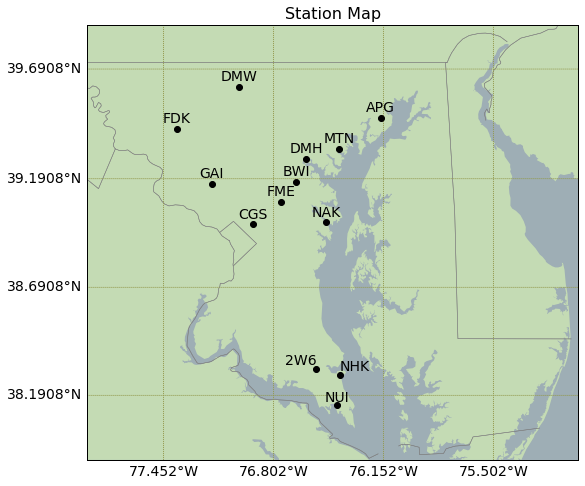

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(9, 8))

center_lat = 38.690760
center_lon = -76.401987
m = Basemap(projection='merc',lat_ts=center_lat,
            llcrnrlat=center_lat-0.8,urcrnrlat=center_lat+1.2,
            llcrnrlon=center_lon-1.5,urcrnrlon=center_lon+1.4, 
            resolution='h', ax=ax)
m.fillcontinents(color="#c4dbb4", lake_color='#9eaeb5')
m.drawmapboundary(fill_color="#9eaeb5")
#m.drawcoastlines(color='gray')
m.drawstates(color='gray')

parallels = np.arange(center_lat-0.50,center_lat+1.25,0.5)
meridians = np.arange(center_lon-1.7,center_lon+1.55,0.65)
m.drawparallels(parallels,labels=[True,False,True,False],color='#93994d',size=14)
m.drawmeridians(meridians,labels=[True,False,False,True],color='#93994d',size=14)

# Station Labels:
for stn in ds.get_index('station'):
    x, y = m(ds.sel(station=stn).lon, ds.sel(station=stn).lat)
    ax.scatter(x,y,zorder=3,c='k')
    if stn == '2W6':
        ax.text(x,y*1.01,stn,size=14,ha='right',va='bottom')
    elif stn == 'NHK':
        ax.text(x,y*1.01,stn,size=14,ha='left',va='bottom')
    else:
        ax.text(x,y*1.01,stn,size=14,ha='center',va='bottom')

    ax.tick_params(size=14)
    ax.set_title('Station Map',size=16)
plt.show()

# Define "onshore" for each station

In [9]:
# Stations defined: 2W6 APG  BWI  CGS  DMH  DMW  FDK  FME  GAI  MTN  NAK  NHK  NUI
stn_dir_top_met = [  5,  50,  60,  80,  80, 105,  95,  65,  85,  70,  20, -10,   0]
stn_dir_bot_met = [140, 200, 160, 120, 160, 135, 125, 125, 115, 190, 190, 170, 150]
##stn_dir_top_met = [  5,  70,  60,  80,  80, 125, 105,  65,  90,  70,  20, -10,   0]
##stn_dir_bot_met = [150, 210, 120, 120, 160, 135, 115, 125, 110, 190, 190, 170, 150]

ds['onshore_min_deg'] = (['station'],stn_dir_top_met)
ds['onshore_max_deg'] = (['station'],stn_dir_bot_met)

In [10]:
region = ['coastal','coastal','coastal','coastal','coastal','inland','inland',
          'coastal','inland','coastal','coastal','coastal','coastal']
ds['region'] = (['station'],region)

### What does "onshore" look like?

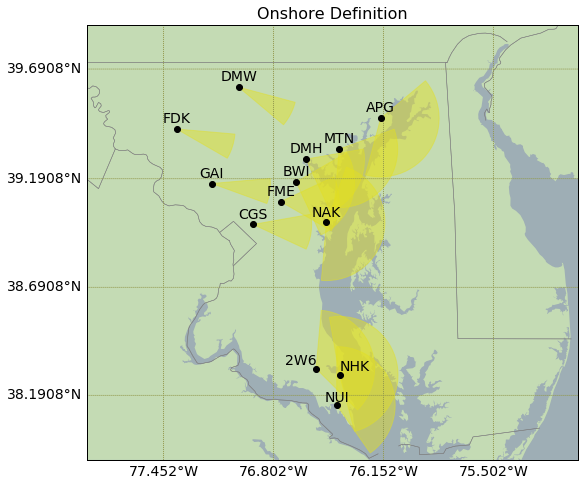

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(9, 8))

center_lat = 38.690760
center_lon = -76.401987
m = Basemap(projection='merc',lat_ts=center_lat,
            llcrnrlat=center_lat-0.8,urcrnrlat=center_lat+1.2,
            llcrnrlon=center_lon-1.5,urcrnrlon=center_lon+1.4, 
            resolution='h', ax=ax)
m.fillcontinents(color="#c4dbb4", lake_color='#9eaeb5')
m.drawmapboundary(fill_color="#9eaeb5")
#m.drawcoastlines(color='gray')
m.drawstates(color='gray')

parallels = np.arange(center_lat-0.50,center_lat+1.25,0.5)
meridians = np.arange(center_lon-1.7,center_lon+1.55,0.65)
m.drawparallels(parallels,labels=[True,False,True,False],color='#93994d',size=14)
m.drawmeridians(meridians,labels=[True,False,False,True],color='#93994d',size=14)

for stn in ds.get_index('station'):
#for stn in ['NHK','NAK','BWI','DMH','MTN','APG']:
    x, y = m(ds.sel(station=stn).lon.data, ds.sel(station=stn).lat.data)
    ax.scatter(x,y,zorder=3,c='k')
    if stn == '2W6':
        ax.text(x,y*1.01,stn,size=14,ha='right',va='bottom')
    elif stn == 'NHK':
        ax.text(x,y*1.01,stn,size=14,ha='left',va='bottom')
    else:
        ax.text(x,y*1.01,stn,size=14,ha='center',va='bottom')
    
    pts  = np.arange(ds.sel(station=stn).onshore_min_deg.data,ds.sel(station=stn).onshore_max_deg.data,5.0)
    npts = pts.size
    fill_x = [x]
    fill_y = [y]
    for dd,wdir in enumerate(pts):
        d = 270.0 - wdir    # Convert met degrees to polar
        plt_dist = -30000.0 # Met degrees are FROM dir... need negative distance!
        fill_x.append(x+plt_dist*np.cos(np.radians(d)))
        fill_y.append(y+plt_dist*np.sin(np.radians(d)))

    plt.fill(fill_x, fill_y,alpha=0.45,lw=None,color='#e3e022')

ax.tick_params(size=14)
ax.set_title('Onshore Definition',size=16)
plt.show()

# Convert to m/s

In [12]:
ds['wspd'] = ds['sknt']*0.514444444444
ds = ds.rename_vars({'drct':'wdir'})
#ang = np.radians(270. - ds['dir'])
#ds['u'] = ds['spd'] * np.cos(ang)
#ds['v'] = ds['spd'] * np.sin(ang)

In [13]:
ds

<xarray.Dataset>
Dimensions:            (datetime: 1385884, station: 13)
Coordinates:
  * datetime           (datetime) datetime64[ns] 2011-01-01T00:15:00 ... 2019-09-30T23:56:00
  * station            (station) object '2W6' 'APG' 'BWI' ... 'NAK' 'NHK' 'NUI'
    lon                (station) float64 -76.55 -76.17 -76.67 ... -76.41 -76.43
    lat                (station) float64 38.32 39.47 39.18 ... 38.99 38.29 38.15
Data variables:
    tmpf               (datetime, station) float64 nan nan nan ... nan nan nan
    dwpf               (datetime, station) float64 nan nan nan ... nan nan nan
    relh               (datetime, station) float64 nan nan nan ... nan nan nan
    wdir               (datetime, station) float64 nan nan nan ... nan nan nan
    sknt               (datetime, station) float64 nan nan nan ... nan nan nan
    p01i               (datetime, station) float64 nan nan nan ... nan nan nan
    alti               (datetime, station) float64 nan nan nan ... nan nan nan
    mslp   

<br>

<br>

***
***

<br>


# Need to loop over stations to find breezes

### Criteria:

In [18]:
# Start time:     0900 Local (1300 UTC) 
start_time = pd.to_timedelta(13,unit='h')
# End time:       1600 Local (2000 UTC)
end_time   = pd.to_timedelta(20,unit='h')

year_range = np.arange(2017,2019,1)
nyears = year_range.size

# Which month to start from:
month_start  = 5
# How many months to look at:
period_len   = 5 
    
# Minimum number of data points (on average)...
#... for a station to be considered.
min_points = 3

light_winds = 3.08667 # m/s

sample_rate = '60min'

# Check number of data points for each station
### We're looking at a 7 hour period (8 datapoints expected)... need to see which stations have that, on average

In [ ]:
spd_count = np.zeros((nyears,nstations))
dir_count = np.zeros((nyears,nstations))
tmp_count = np.zeros((nyears,nstations))

for yy,year in enumerate(year_range):
    period_start = pd.to_datetime('{0}-{1:0d}-01 00:00:00'.format(year,month_start))
    period_end   = pd.to_datetime('{0}-{1:0d}-01 00:00:00'.format(year,month_start+period_len)) 


    day_count = 0
    for day in pd.date_range(start=period_start, end=period_end)[:-1]:
        period = ds.sel(datetime=slice(str(pd.to_datetime(day)+start_time),
                                    str(pd.to_datetime(day)+end_time)))
        day_count += 1
        for ss,stn in enumerate(ds.get_index('station')):
            station     = period.sel(station=stn)
            station_spd = station.sknt.dropna(dim='datetime',how='any')
            station_dir = station.dir.dropna(dim='datetime',how='any')
            station_tmp = station.tmpf.dropna(dim='datetime',how='any')
            spd_count[yy,ss] += station_spd.shape[0]
            dir_count[yy,ss] += station_dir.shape[0]
            tmp_count[yy,ss] += station_tmp.shape[0]        


In [ ]:
fig,ax = plt.subplots(ncols=3,figsize=(12,5),sharey=True,sharex=True)
for ss,stn in enumerate(ds.get_index('station')):
    ax[0].plot(year_range,spd_count[:,ss]/float(day_count),label=stn)
    ax[1].plot(year_range,dir_count[:,ss]/float(day_count),label=stn)
    ax[2].plot(year_range,tmp_count[:,ss]/float(day_count),label=stn)
    ax[2].legend(loc=(1.01,0.00),frameon=False)
    ax[0].set_xticks(year_range)
    ax[0].fill_between([2000,2030],0,min_points,color='grey',alpha=0.02,lw=0.0)
    ax[1].fill_between([2000,2030],0,min_points,color='grey',alpha=0.02,lw=0.0)
    ax[2].fill_between([2000,2030],0,min_points,color='grey',alpha=0.02,lw=0.0)
    ax[0].set_xlim(np.min(year_range),np.max(year_range))
    ax[0].set_ylim(0,50)

In [ ]:
good_stations_spd = []
good_stations_dir = []
good_stations_tmp = []

good_stations  = []
meet_wind_reqs = []
bad_stations   = []

        
for ss,stn in enumerate(ds.get_index('station')):
    meets_minimum_threshold_spd = np.all(spd_count[:,ss]/float(day_count)>=min_points)
    meets_minimum_threshold_dir = np.all(dir_count[:,ss]/float(day_count)>=min_points)
    meets_minimum_threshold_tmp = np.all(tmp_count[:,ss]/float(day_count)>=min_points)
    print('{}: Speed - {}\tDir - {}\t Temp - {}'.format(stn,meets_minimum_threshold_spd,
                                                        meets_minimum_threshold_dir,meets_minimum_threshold_tmp))
    if meets_minimum_threshold_spd: good_stations_spd.append(stn)
    if meets_minimum_threshold_dir: good_stations_dir.append(stn)
    if meets_minimum_threshold_tmp: good_stations_tmp.append(stn)
        
    if meets_minimum_threshold_spd and meets_minimum_threshold_dir and meets_minimum_threshold_tmp:
        good_stations.append(stn)
    elif meets_minimum_threshold_spd and meets_minimum_threshold_dir and ~meets_minimum_threshold_tmp:
        meet_wind_reqs.append(stn)
    else:
        bad_stations.append(stn)        
bad_stations_spd = []
bad_stations_dir = []
bad_stations_tmp = []
for stn in ds.get_index('station'):
    if stn not in good_stations_spd: bad_stations_spd.append(stn)
    if stn not in good_stations_dir: bad_stations_dir.append(stn)
    if stn not in good_stations_tmp: bad_stations_tmp.append(stn)
stations_list = good_stations + meet_wind_reqs

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 8))

center_lat = 38.690760
center_lon = -76.401987
m = Basemap(projection='merc',lat_ts=center_lat,
            llcrnrlat=center_lat-0.8,urcrnrlat=center_lat+1.2,
            llcrnrlon=center_lon-1.5,urcrnrlon=center_lon+1.4, 
            resolution='h', ax=ax)
m.fillcontinents(color="#c4dbb4", lake_color='#9eaeb5')
m.drawmapboundary(fill_color="#9eaeb5")
#m.drawcoastlines(color='gray')
m.drawstates(color='gray')

parallels = np.arange(center_lat-0.50,center_lat+1.25,0.5)
meridians = np.arange(center_lon-1.7,center_lon+1.55,0.65)
m.drawparallels(parallels,labels=[True,False,True,False],color='#93994d',size=14)
m.drawmeridians(meridians,labels=[True,False,False,True],color='#93994d',size=14)

# Station Labels:
for stn in good_stations:
    x, y = m(ds.sel(station=stn).lon, ds.sel(station=stn).lat)
    ax.scatter(x,y,zorder=3,c='k')
    if stn == '2W6':
        ax.text(x,y*1.01,stn,size=14,ha='right',va='bottom')
    elif stn == 'NHK':
        ax.text(x,y*1.01,stn,size=14,ha='left',va='bottom')
    else:
        ax.text(x,y*1.01,stn,size=14,ha='center',va='bottom')

for stn in meet_wind_reqs:
    x, y = m(ds.sel(station=stn).lon, ds.sel(station=stn).lat)
    ax.scatter(x,y,zorder=3,c='b')
    if stn == '2W6':
        ax.text(x,y*1.01,stn,size=14,ha='right',va='bottom',c='b')
    elif stn == 'NHK':
        ax.text(x,y*1.01,stn,size=14,ha='left',va='bottom',c='b')
    else:
        ax.text(x,y*1.01,stn,size=14,ha='center',va='bottom',c='b')
        
for stn in bad_stations:
    x, y = m(ds.sel(station=stn).lon, ds.sel(station=stn).lat)
    ax.scatter(x,y,zorder=3,c='r')
    if stn == '2W6':
        ax.text(x,y*1.01,stn,size=14,ha='right',va='bottom',c='r')
    elif stn == 'NHK':
        ax.text(x,y*1.01,stn,size=14,ha='left',va='bottom',c='r')
    else:
        ax.text(x,y*1.01,stn,size=14,ha='center',va='bottom',c='r')
ax.tick_params(size=14)
ax.set_title('Stations Meeting Threshold',size=16)
plt.show()

# Finding a Bay Breeze

From Stauffer and Thompson, 2015: </br>

For each day, the daytime (0900 to 1600 Eastern Standard Time, EST) wind directions were evaluated (Fig. 3a). 
    
   1. <font color='green'>If the hourly wind direction measurement changed from either offshore (160º to 360º at KLFI; 170º to 50º at KBWI), calm, or light and variable (less than 6 kt), >to onshore (10º to 150º at KLFI; 60º to 160º at KBWI) sustained for two or more consecutive hours during the period... </font>
    
   2. <font color='green'>If there was no evidence of a large-scale circulation causing the wind shift to onshore directions... 
   
       the corresponding wind direction and speed were checked at the respective inland surface station (Fig. 3e; KRIC for Hampton; KIAD for Baltimore). This check was performed to attempt to eliminate synoptic-scale winds that were observed by both stations, indicating a larger-scale effect. If the corresponding inland wind directions were not from the same onshore wind directions for two or more hours or wind speeds were less than 3 ms−1 from any direction, then the day was grouped with bay breeze days.</font>

In [ ]:
def find_bay_breeze(wdir, wspd, onshore_lwr_lim, onshore_upr_lim, sample_rate):
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - # 
    # Define limits for the Bay Breeze:                                           #
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - # 
    offshore_time_limit = 1.0 # Must be offshore for X hours before BB
    onshore_time_limit  = 2.0 # Must be onshore for X hours 

    offshore_spd_limit  = 6.0 # Offshore winds calm, light, or variable (lt 6 knts)
    onshore_spd_limit   = 6.0 # Onshore winds sustained (gt 6 knts)
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  - - - - #
    bay_breeze_detected = False
    offshore_time_start,bay_breeze_passage,bay_breeze_end = None, None, None
    is_onshore = ((wdir>=onshore_lwr_lim) & (wdir <= onshore_upr_lim)).data
    is_offshore = ~is_onshore        
    
    offshore = ['']*wdir.size
    onshore  = ['']*wdir.size
    off_lbl = 'a'
    on_lbl = 'a'

    new_off_lbl = False
    new_on_lbl = True
    for ii in range(0,wdir.size):
        if is_onshore[ii]:
            onshore[ii] = '{}'.format(on_lbl)
            new_on_lbl = False
            if new_off_lbl == False:
                off_lbl = chr(ord(off_lbl)+1)
                new_off_lbl = True
                
        if is_offshore[ii]:
            offshore[ii] = '{}'.format(off_lbl)
            new_off_lbl = False
            if new_on_lbl == False:
                on_lbl = chr(ord(on_lbl)+1)
                new_on_lbl = True
    offshore_count = Counter(offshore) 
    onshore_count  = Counter(onshore)
    for lbl in offshore_count.keys():
        if len(lbl) > 0:
            if lbl in onshore_count.keys():
                offshore_time = offshore_count[lbl]*pd.to_timedelta(sample_rate) / np.timedelta64(1, 'h')
                onshore_time  = onshore_count[lbl]*pd.to_timedelta(sample_rate) / np.timedelta64(1, 'h')
                if offshore_time >= 1.0 and onshore_time >= 2.0:
                    mean_offshore_spd = wspd[np.where(np.asarray(offshore)==lbl)].mean()
                    mean_onshore_spd  = wspd[np.where(np.asarray(onshore)==lbl)].mean()
                    mean_onshore_dir  = wdir[np.where(np.asarray(onshore)==lbl)].mean()
                    print('Time: good - checking speed...')
                    if mean_offshore_spd <= offshore_spd_limit and mean_onshore_spd >= onshore_spd_limit:
                        print('Bay Breeze Detected!')
                        bay_breeze_detected = True
                        offshore_time_start = wspd[np.where(np.asarray(offshore)==lbl)].datetime[0].data
                        bay_breeze_passage  = wspd[np.where(np.asarray(onshore)==lbl)].datetime[0].data
                        bay_breeze_end      = wspd[np.where(np.asarray(onshore)==lbl)].datetime[-1].data

    return bay_breeze_detected,offshore_time_start,bay_breeze_passage,bay_breeze_end
            

In [ ]:
def validate_bay_breeze(ds_day, bay_breeze_stn, offshore_start, bay_breeze_start, bay_breeze_end):
    bay_breeze_validated = False
    onshore_lwr_lim = ds_day.sel(station=bay_breeze_stn).onshore_min_deg.data
    onshore_upr_lim = ds_day.sel(station=bay_breeze_stn).onshore_max_deg.data
    inland_onshore = 0
    for stn in ds_day.get_index('station'):
        if ds_day.sel(station=stn).region == 'inland': 
            inland_slice = ds_day.sel(datetime=slice(str(offshore_start),str(bay_breeze_start)))
            inland_mean_dir = inland_slice.sel(station=stn).dir.dropna(dim='datetime',how='all').mean()
            inland_mean_spd = inland_slice.sel(station=stn).sknt.dropna(dim='datetime',how='all').mean()
            is_onshore = ((inland_mean_dir>=onshore_lwr_lim) & (inland_mean_dir <= onshore_upr_lim)).data
            if is_onshore and inland_mean_spd > 3.0:
                inland_onshore += 1
    if inland_onshore == 0:
        bay_breeze_validated = True
    return bay_breeze_validated

In [ ]:
sample_rate = '60min'


for yy,year in enumerate(year_range):
    period_start = pd.to_datetime('{0}-{1:0d}-01 00:00:00'.format(year,month_start))
    #period_start = pd.to_datetime('{0}-{1:0d}-08 00:00:00'.format(year,month_start)) # Bay-Breeze Day
    period_end   = pd.to_datetime('{0}-{1:0d}-01 00:00:00'.format(year,month_start+period_len)) 
    for dd,day in enumerate(pd.date_range(start=period_start, end=period_end)[:-1]):
        print(day)
        period = ds.sel(datetime=slice(str(pd.to_datetime(day)+start_time),
                                    str(pd.to_datetime(day)+end_time)))
        bay_breeze_count = 0
        bay_breeze_stn   = []
        for ss,stn in enumerate(stations_list):
        #for ss,stn in enumerate(['BWI']):
            #print(stn)
            station     = period.sel(station=stn)
            onshore_lwr_lim = station.onshore_min_deg.data
            onshore_upr_lim = station.onshore_max_deg.data
            station_spd = station.sknt.dropna(dim='datetime',how='all')
            station_dir = station.dir.dropna(dim='datetime',how='all')
            #station_tmp = station_tmp.dropna(dim='datetime',how='any')
            if station_spd.size > min_points and station_dir.size > min_points:
                station_spd = station_spd.resample(datetime=sample_rate).interpolate('linear')
                station_dir = station_dir.resample(datetime=sample_rate).interpolate('linear')
                #station_tmp = station_tmp.resample(datetime=sample_rate).interpolate('linear')
                
                bay_breeze_detected,offshore_start_time,bay_breeze_start, bay_breeze_end = find_bay_breeze(
                                                                    station_dir, station_spd, onshore_lwr_lim, 
                                                                    onshore_upr_lim, sample_rate)
                if bay_breeze_detected: 
                    bay_breeze_validated = validate_bay_breeze(period, stn, offshore_start_time, 
                                                               bay_breeze_start, bay_breeze_end)
                    if bay_breeze_validated: 
                        print('Bay Breeze Validated!')
                        bay_breeze_count += 1
                        bay_breeze_stn.append(stn)
                        fig,ax = plt.subplots(nrows=2,sharex=True)
                        station_spd.plot(ax=ax[0])
                        station_dir.plot(ax=ax[1])
                        #ax[1].axhline(pd.date_range(period_start,period_end),onshore_lwr_lim)
                        ax[1].fill_between(pd.date_range(period_start,period_end),onshore_lwr_lim,onshore_upr_lim,
                                        color='k',alpha=0.2)
                        ax[1].set_xlim(str(period.datetime[0].data),str(period.datetime[-1].data))
                        ax[1].set_ylim(0.0,360.0)
                        plt.show()
            #else: print('not enough data. Skipping station.')
        if bay_breeze_count > 0: print(bay_breeze_stn)
                
        

In [20]:
def detect_bay_breeze(station, sample_rate='60min', light_winds=3.08667):
    station_spd = station.wspd.dropna(dim='datetime',how='any').resample(
                                                    datetime=sample_rate).interpolate('linear')
    station_dir = station.wdir.dropna(dim='datetime',how='any').resample(
                                                    datetime=sample_rate).interpolate('linear')
    #station_tmp = station.temp.dropna(dim='datetime',how='any').resample(
    #                                               datetime=sample_rate).interpolate('linear')

    is_onshore  = ((station_dir>=station.onshore_min_deg) & (station_dir <= station.onshore_max_deg)
                    & (station_dir <= 360.0)).data.squeeze()
    is_offshore = ((station_dir<station.onshore_min_deg) | \
                  ((station_dir>station.onshore_max_deg) & (station_dir<=360.0))).data.squeeze()
    is_lt_vrb   = ((station_spd<light_winds) & (station_dir > 360.0)).data
    offshore_conditions = is_lt_vrb | is_offshore
    #print('   offshore: {}'.format(is_offshore))
    #print('light & vrb: {}'.format(is_lt_vrb))
    #print(' eaither or: {}'.format(offshore_conditions))
    #print('    onshore: {}'.format(is_onshore))
    bay_breeze_detected = False
    bay_breeze_start    = None
    bay_breeze_pass     = None
    bay_breeze_end      = None
    if np.any(offshore_conditions) and np.any(is_onshore):
        offshore = ['']*station_dir.size
        onshore  = ['']*station_dir.size
        off_lbl = 'a'
        on_lbl = 'a'

        new_off_lbl = False
        new_on_lbl = True
        for ii in range(0,station_dir.size):
            if is_onshore[ii]:
                onshore[ii] = '{}'.format(on_lbl)
                new_on_lbl = False
                if new_off_lbl == False:
                    off_lbl = chr(ord(off_lbl)+1)
                    new_off_lbl = True

            elif offshore_conditions[ii]:
                offshore[ii] = '{}'.format(off_lbl)
                new_off_lbl = False
                if new_on_lbl == False:
                    on_lbl = chr(ord(on_lbl)+1)
                    new_on_lbl = True
            else:
                if offshore_conditions[ii-1]:  
                    off_lbl = chr(ord(off_lbl)+1)
                    on_lbl = off_lbl
                    new_off_lbl = False
                elif is_onshore[ii-1]:
                    on_lbl = chr(ord(on_lbl)+1)
                    new_on_lbl = True
                    #off_lbl = chr(ord(off_lbl)+1)
                    #new_on_lbl = False

        #    print(off_lbl,on_lbl)
        #print(offshore)
        #print(onshore)
        offshore_count = Counter(offshore) 
        onshore_count  = Counter(onshore)
        for lbl in offshore_count.keys():
            if len(lbl) > 0:
                if lbl in onshore_count.keys():
                    offshore_time = (offshore_count[lbl]-1)*pd.to_timedelta(sample_rate) / np.timedelta64(1, 'h')
                    onshore_time  = (onshore_count[lbl]-1)*pd.to_timedelta(sample_rate) / np.timedelta64(1, 'h')
                    #print('Label {} offshore: {} hours'.format(lbl,offshore_time))
                    #print('Label {} onshore:  {} hours'.format(lbl,onshore_time))
                    if offshore_time >= 1.0 and onshore_time >= 2.0:
                        print('BAY BREEZE DETECTED')
                        bay_breeze_start = station_spd.datetime[np.where(np.asarray(offshore)==lbl)[0][0]]
                        bay_breeze_pass  = station_spd.datetime[np.where(np.asarray(onshore)==lbl)[0][0]]
                        bay_breeze_end   = station_spd.datetime[np.where(np.asarray(onshore)==lbl)[0][-1]]
                        print(bay_breeze_start.data)
                        print(bay_breeze_pass.data)
                        print(bay_breeze_end.data)
                        bay_breeze_detected = True

    return(bay_breeze_detected,bay_breeze_start,bay_breeze_pass,bay_breeze_end)

BAY BREEZE DETECTED
2017-05-12T13:00:00.000000000
2017-05-12T15:00:00.000000000
2017-05-12T19:00:00.000000000


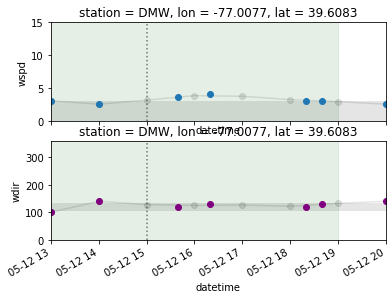

BAY BREEZE DETECTED
2018-05-06T17:00:00.000000000
2018-05-06T14:00:00.000000000
2018-05-06T16:00:00.000000000


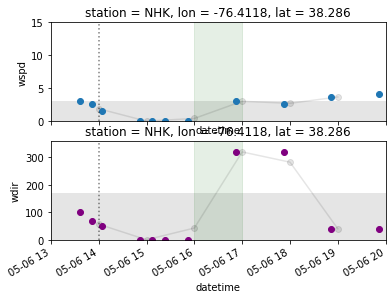

BAY BREEZE DETECTED
2018-05-08T13:00:00.000000000
2018-05-08T15:00:00.000000000
2018-05-08T17:00:00.000000000


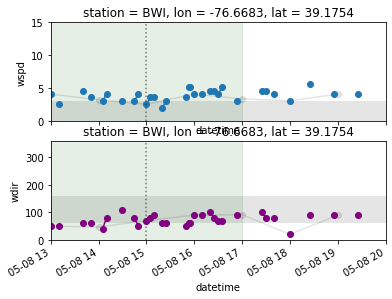

BAY BREEZE DETECTED
2018-06-02T17:00:00.000000000
2018-06-02T14:00:00.000000000
2018-06-02T16:00:00.000000000


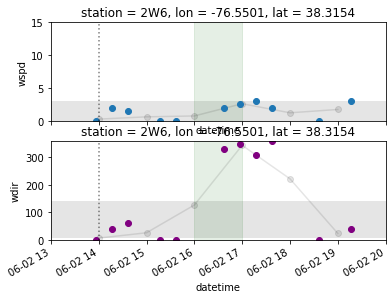

BAY BREEZE DETECTED
2018-06-09T13:00:00.000000000
2018-06-09T15:00:00.000000000
2018-06-09T17:00:00.000000000


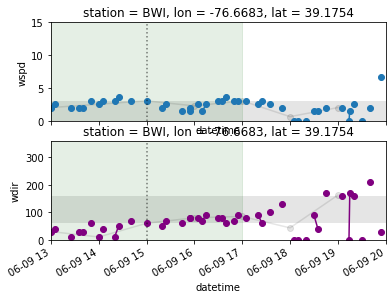

BAY BREEZE DETECTED
2018-07-24T17:00:00.000000000
2018-07-24T14:00:00.000000000
2018-07-24T16:00:00.000000000


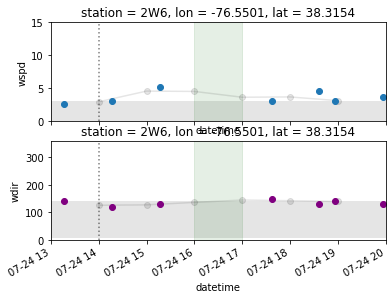

BAY BREEZE DETECTED
2018-08-30T14:00:00.000000000
2018-08-30T16:00:00.000000000
2018-08-30T18:00:00.000000000


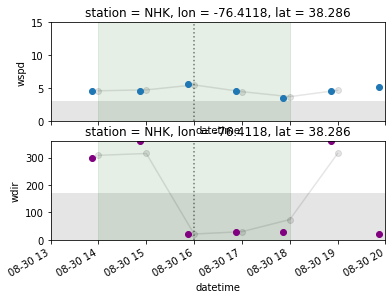

BAY BREEZE DETECTED
2018-09-30T13:00:00.000000000
2018-09-30T16:00:00.000000000
2018-09-30T18:00:00.000000000


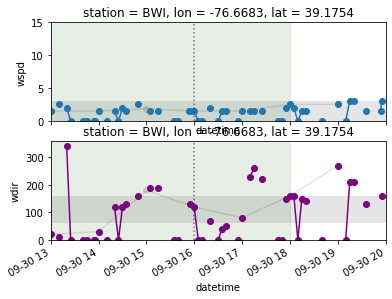

In [22]:
nstations = np.shape(ds.get_index('station'))[0]
spd_count = np.zeros((nyears,nstations))
dir_count = np.zeros((nyears,nstations))
tmp_count = np.zeros((nyears,nstations))

for yy,year in enumerate(year_range):
    period_start = pd.to_datetime('{0}-{1:0d}-01 00:00:00'.format(year,month_start))
    period_end   = pd.to_datetime('{0}-{1:0d}-01 00:00:00'.format(year,month_start+period_len)) 


    day_count = 0
    for day in pd.date_range(start=period_start, end=period_end):
        period = ds.sel(datetime=slice(str(pd.to_datetime(day)+start_time),
                                    str(pd.to_datetime(day)+end_time)))
        day_count += 1
        for ss,stn in enumerate(ds.get_index('station')):
            station     = period.sel(station=stn)
            if station.wspd.dropna(dim='datetime',how='any').size >= min_points & \
            station.wdir.dropna(dim='datetime',how='any').size >= min_points:
                bay_breeze_detected, bb_start, bb_passage, bb_end = detect_bay_breeze(station)
            else:
                bay_breeze_detected = False
            
            if bay_breeze_detected:

                fig,ax = plt.subplots(nrows=2,sharex=True)
                station_spd = station.wspd.dropna(dim='datetime',how='any').resample(
                                                datetime=sample_rate).interpolate('linear')
                station_dir = station.wdir.dropna(dim='datetime',how='any').resample(
                                                datetime=sample_rate).interpolate('linear')
                station_spd.plot.line(marker='o',c='k',ax=ax[0],alpha=0.1)
                station.wspd.plot.line(marker='o',ax=ax[0])
                ax[0].set_ylim(0,15)
                ax[0].fill_between([pd.to_datetime('2000'),
                                  pd.to_datetime('2030')],0.0,light_winds,color='grey',alpha=0.2,lw=0.0)
                station_dir.plot.line(marker='o',c='k',ax=ax[1],alpha=0.1)
                station.wdir.plot.line(color='purple', marker='o',ax=ax[1])
                ax[1].fill_between([pd.to_datetime('2000'),
                                  pd.to_datetime('2030')],station.onshore_min_deg,station.onshore_max_deg,color='grey',alpha=0.2,lw=0.0)
                ax[1].set_xlim(period.datetime.data[0],period.datetime.data[-1])
                ax[1].set_ylim(0,360)
                ax[0].fill_betweenx(np.arange(0,100),pd.to_datetime(bb_start.data),
                                    pd.to_datetime(bb_end.data),alpha=0.1, color='darkgreen')
                ax[0].axvline(pd.to_datetime(bb_passage.data),c='k',ls=':',alpha=0.5)
                ax[1].axvline(pd.to_datetime(bb_passage.data),c='k',ls=':',alpha=0.5)
                ax[1].fill_betweenx(np.arange(0,400),pd.to_datetime(bb_start.data),
                                    pd.to_datetime(bb_end.data),alpha=0.1, color='darkgreen')
            plt.show()                  
